In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Simulation parameters
Vin = 12.0          # Input voltage (V)
Vref = 5.0          # Target output voltage (V)
fs = 50000          # Switching frequency (Hz)
Ts = 1 / fs         # Time step (s)
Tsim = 0.02         # Simulation time (s)
steps = int(Tsim / Ts)

# Buck converter components
L = 220e-6          # Inductor (H)
C = 470e-6          # Capacitor (F)
R_normal = 5.0      # Normal load 
R_overload = 1.67   # Overload 

print("Parameters set. Vin=12V, Target=5V, Normal Load=5Ω, Overload=1.67Ω")

Parameters set. Vin=12V, Target=5V, Normal Load=5Ω, Overload=1.67Ω


In [35]:
def simulate_buck(Kp, Ki, R_load, Tsim_local=None, anti_windup=True):
    Tsim_use = Tsim if Tsim_local is None else Tsim_local
    steps_local = int(Tsim_use / Ts)
    iL = 0.0
    Vc = 0.0
    integral = 0.0
    time, Vout, Duty, IL = [], [], [], []

    for n in range(steps_local):
        error = Vref - Vc

        # Controller output
        D = Kp*error + Ki*integral
        
        # Anti-windup and clamping
        if anti_windup:
            tentative_D = D
            D = max(0.0, min(1.0, D))
            if D < 1.0 and D > 0.0:
                 integral += error * Ts
            elif D == 1.0 and error > 0:
                 integral += error * Ts
            elif D == 0.0 and error < 0:
                 integral += error * Ts
        else:
            integral += error * Ts
            D = max(0.0, min(1.0, D))

        # Buck dynamics
        Vswitch = D * Vin
        diL = (Vswitch - Vc) / L * Ts
        iL += diL
        dVc = (iL - Vc / R_load) / C * Ts
        Vc += dVc

        time.append(n*Ts)
        Vout.append(Vc)
        Duty.append(D)
        IL.append(iL)

    return np.array(time), np.array(Vout), np.array(Duty), np.array(IL)

In [36]:
# Manual PI Gain Tuning
# Kp: Controls the speed of response. Higher Kp = faster, more oscillatory.
# Ki: Eliminates steady-state error. Higher Ki = faster error elimination.
Kp_tuned = 10.0
Ki_tuned = 500.0
print(f"Manually tuned PI gains: Kp = {Kp_tuned:.4f}, Ki = {Ki_tuned:.4f}")

# Normal Load Simulation 
t_norm, vout_norm, duty_norm, il_norm = simulate_buck(Kp=Kp_tuned, Ki=Ki_tuned, R_load=R_normal)

Manually tuned PI gains: Kp = 10.0000, Ki = 500.0000


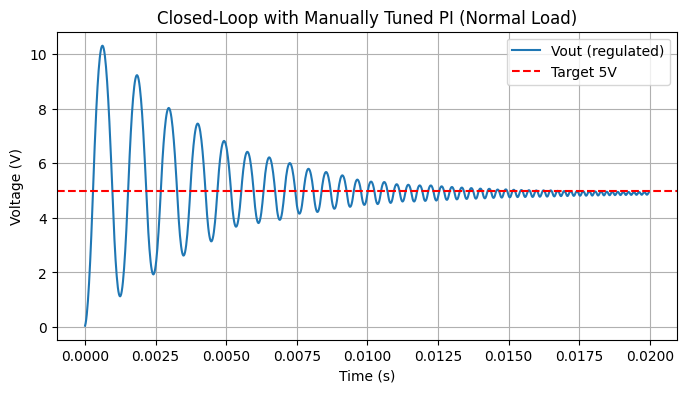

In [37]:
plt.figure(figsize=(8,4))
plt.plot(t_norm, vout_norm, label="Vout (regulated)")
plt.axhline(Vref, color='r', linestyle='--', label="Target 5V")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Closed-Loop with Manually Tuned PI (Normal Load)")
plt.legend()
plt.grid()
plt.show()

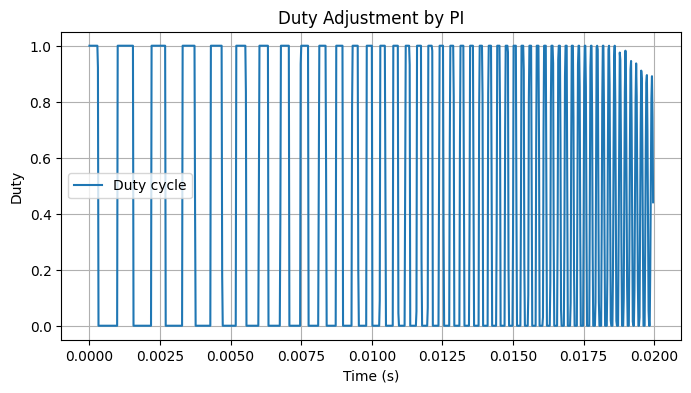

In [38]:
plt.figure(figsize=(8,4))
plt.plot(t_norm, duty_norm, label="Duty cycle")
plt.xlabel("Time (s)")
plt.ylabel("Duty")
plt.title("Duty Adjustment by PI")
plt.grid()
plt.legend()
plt.show()

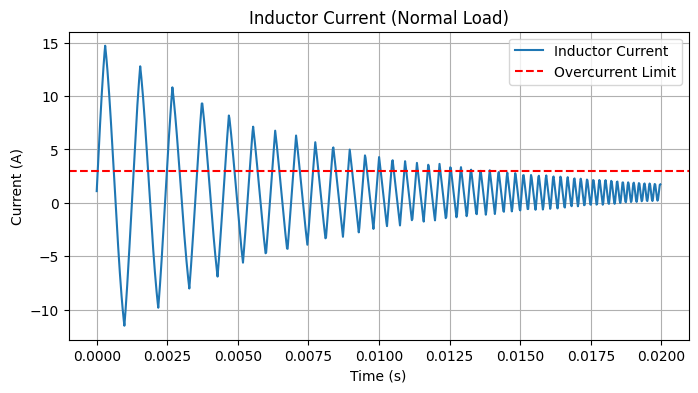

In [39]:
plt.figure(figsize=(8,4))
plt.plot(t_norm, il_norm, label="Inductor Current")
plt.axhline(3.0, color='r', linestyle='--', label="Overcurrent Limit")
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Inductor Current (Normal Load)")
plt.legend()
plt.grid()
plt.show()

In [40]:
# Overload Simulation and Fault Detection
limit_I = 3.0   # A
limit_V = 5.5   # V

t_ovl, vout_ovl, duty_ovl, il_ovl = simulate_buck(Kp=Kp_tuned, Ki=Ki_tuned, R_load=R_overload)

# Fault detection logic
fault = "None"
if np.max(il_ovl) > limit_I:
    fault = "Overcurrent"
elif np.max(vout_ovl) > limit_V:
    fault = "Overvoltage"


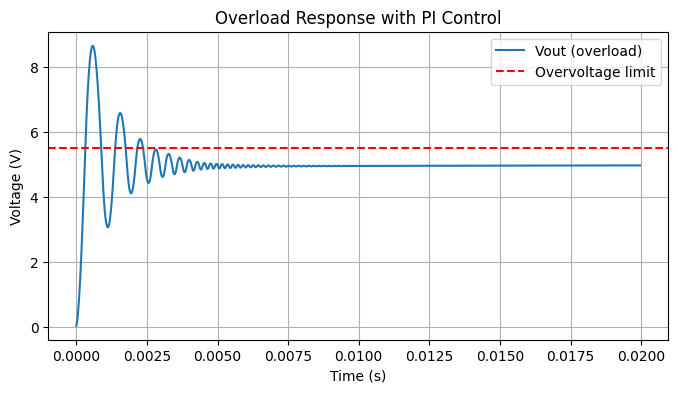

In [41]:
plt.figure(figsize=(8,4))
plt.plot(t_ovl, vout_ovl, label="Vout (overload)")
plt.axhline(limit_V, color='r', linestyle='--', label="Overvoltage limit")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Overload Response with PI Control")
plt.legend()
plt.grid()
plt.show()

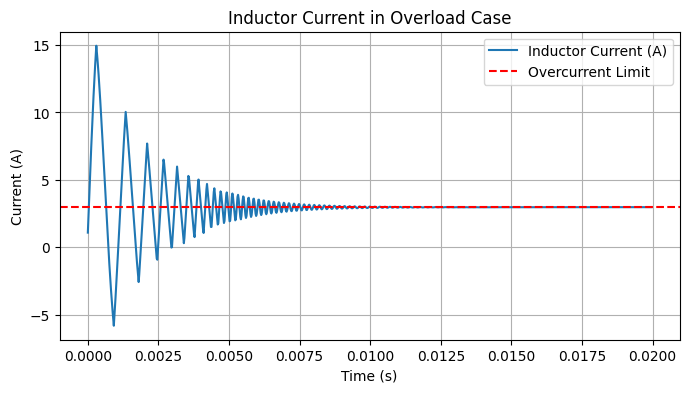

In [42]:
plt.figure(figsize=(8,4))
plt.plot(t_ovl, il_ovl, label="Inductor Current (A)")
plt.axhline(limit_I, color='r', linestyle='--', label="Overcurrent Limit")
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Inductor Current in Overload Case")
plt.legend()
plt.grid()
plt.show()

In [43]:
print("Fault detected:", fault)

Fault detected: Overcurrent
